In [1]:
# Import required libraries
import sys
sys.path.append('../..')

from utilities.performance_utils import PerformanceTracker, benchmark_operation, generate_test_data
from configs.cdf_config import config
import pandas as pd
import numpy as np
import time
import json
from datetime import datetime, timedelta


try:
    # Data modeling schema classes (using Apply suffix)
    from cognite.client.data_classes.data_modeling import (
        DataModelApply, ViewApply, SpaceApply,
        NodeApply, EdgeApply, PropertyOptions,
        ContainerApply, ContainerProperty,
        MappedPropertyApply, InstanceApply,
        NodeOrEdgeData

    )
    # ID classes for referencing objects
    from cognite.client.data_classes.data_modeling.ids import (
        ContainerId, ViewId, DataModelId
    )
    from cognite.client.data_classes.data_modeling.data_types import (
        Text, Float64, Timestamp, Boolean, Int64
    )
    from cognite.client.data_classes.data_modeling.views import (
        ViewPropertyApply,
        ConnectionDefinitionApply
    )

    CDF_IMPORTS_AVAILABLE = True
    print("✅ Successfully imported data modeling classes for SDK v7.76")
    print("   Classes available: SpaceApply, ContainerApply, ViewApply, DataModelApply")
    print("   Instance classes: InstanceApply, NodeApply, EdgeApply")
except ImportError as e:
    print(f"❌ CDF SDK imports not available: {e}")
    print("Please upgrade cognite-sdk: pip install cognite-sdk --upgrade")
    CDF_IMPORTS_AVAILABLE = False


# For plotting (optional)
try:
    import matplotlib.pyplot as plt
    plt.style.use('default')
    PLOTTING_AVAILABLE = True
    print("✅ Matplotlib available for plotting")
except ImportError:
    print("⚠️  Matplotlib not available. Install with: pip install matplotlib")
    PLOTTING_AVAILABLE = False

✅ Successfully imported data modeling classes for SDK v7.76
   Classes available: SpaceApply, ContainerApply, ViewApply, DataModelApply
   Instance classes: InstanceApply, NodeApply, EdgeApply
✅ Matplotlib available for plotting


In [2]:
# Initialize CDF client using the client setup utility
from utilities.client_setup import get_client, test_connection

# Get the configured CDF client
client = get_client()

if client is None:
    print("Failed to create CDF client. Please check your .env file.")
    print("Run: python ../../test_connection.py to test your connection")
else:
    # Test the connection
    if test_connection():
        print("Ready to run performance tests!")
    else:
        print("Connection test failed. Please check your credentials.")



✓ Successfully connected to CDF project: templates-dev
🔍 Testing CDF connection...
📋 Current .env configuration:
----------------------------------------
  CDF_PROJECT: templates-dev
  CDF_CLUSTER: aws-dub-dev
  CDF_BASE_URL: https://aws-dub-dev.cognitedata.com
  DEFAULT_BATCH_SIZE: 1000
  DEFAULT_ITERATIONS: 10
  LOG_LEVEL: INFO
  CDF_CLIENT_ID: 8242****************************a218
  CDF_CLIENT_SECRET: KN98********************************fb.o
  CDF_TENANT_ID: b897****************************1a62
----------------------------------------
✓ Configuration is valid
✓ Successfully connected to CDF project: templates-dev
✓ Connection successful!
  Project: templates-dev


C:\Users\JanIngeBergseth\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py:766: UserWarning: You are using version='7.76.1' of the SDK, however version='7.77.1' is available. To suppress this warning, either upgrade or do the following:
>>> from cognite.client.config import global_config
>>> global_config.disable_pypi_version_check = True
  _threading_Thread_run(self)


  Token is valid and accessible
Ready to run performance tests!


In [3]:
# Create Test Data Model Setup
def setup_test_data_model():
    """Create test space, containers, views, and data model for performance testing."""
    
    if client is None:
        print("❌ Client not available. Run client setup first.")
        return None, [], [], None
    
    print("🏗️ Setting up test data model...")
    timestamp = int(time.time())
    
    # 1. Create test space
    test_space_id = f"perf_test_space_{timestamp}"
    print(f"  Creating test space: {test_space_id}")
    
    try:
        test_space = SpaceApply(
            space=test_space_id,
            name="Performance Test Space",
            description="Space for data modeling performance tests"
        )
        client.data_modeling.spaces.apply([test_space])
        print(f"    ✅ Space created: {test_space_id}")
    except Exception as e:
        print(f"    ❌ Error creating space: {e}")
        return None, [], [], None
    
    # 2. Create test containers
    print("  Creating test containers...")
    containers = []
    container_ids = []
    
    # Asset container
    asset_container = ContainerApply(
        space=test_space_id,
        external_id="AssetContainer",
        name="Asset Container",
        properties={
            "name": ContainerProperty(type=Text()),
            "description": ContainerProperty(type=Text()),
            "status": ContainerProperty(type=Text()),
            "created_time": ContainerProperty(type=Timestamp()),
            "value": ContainerProperty(type=Float64())
        }
    )
    containers.append(asset_container)
    container_ids.append("AssetContainer")
    
    # Equipment container  
    equipment_container = ContainerApply(
        space=test_space_id,
        external_id="EquipmentContainer",
        name="Equipment Container",
        properties={
            "model": ContainerProperty(type=Text()),
            "manufacturer": ContainerProperty(type=Text()),
            "serial_number": ContainerProperty(type=Text()),
            "install_date": ContainerProperty(type=Timestamp()),
            "is_active": ContainerProperty(type=Boolean())
        }
    )
    containers.append(equipment_container)
    container_ids.append("EquipmentContainer")
    
    try:
        client.data_modeling.containers.apply(containers)
        print(f"    ✅ Created {len(containers)} containers")
    except Exception as e:
        print(f"    ❌ Error creating containers: {e}")
        return test_space_id, [], [], None
    
    # 3. Create test views
    print("  Creating test views...")
    views = []
    view_ids = []
    
    # Asset view
    asset_view = ViewApply(
        space=test_space_id,
        external_id="AssetView",
        name="Asset View",
        version="1",
        properties={
            "name": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="name"
            ),
            "description": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="description"
            ),
            "status": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="status"
            ),
            "created_time": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="created_time"
            ),
            "value": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="value"
            )
        }
    )
    views.append(asset_view)
    view_ids.append("AssetView")
    
    # Equipment view
    equipment_view = ViewApply(
        space=test_space_id,
        external_id="EquipmentView", 
        name="Equipment View",
        version="1",
        properties={
            "model": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="model"
            ),
            "manufacturer": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="manufacturer"
            ),
            "serial_number": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="serial_number"
            ),
            "install_date": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="install_date"
            ),
            "is_active": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="is_active"
            )
        }
    )
    views.append(equipment_view)
    view_ids.append("EquipmentView")
    
    try:
        client.data_modeling.views.apply(views)
        print(f"    ✅ Created {len(views)} views")
    except Exception as e:
        print(f"    ❌ Error creating views: {e}")
        return test_space_id, container_ids, [], None
    
    # 4. Create test data model
    print("  Creating test data model...")
    data_model_id = f"PerfTestDataModel_{timestamp}"
    
    try:
        data_model = DataModelApply(
            space=test_space_id,
            external_id=data_model_id,
            name="Performance Test Data Model",
            description="Data model for performance testing",
            version="1",
            views=[
                ViewId(space=test_space_id, external_id="AssetView", version="1"),
                ViewId(space=test_space_id, external_id="EquipmentView", version="1")
            ]
        )
        client.data_modeling.data_models.apply([data_model])
        print(f"    ✅ Created data model: {data_model_id}")
    except Exception as e:
        print(f"    ❌ Error creating data model: {e}")
        return test_space_id, container_ids, view_ids, None
    
    print(f"✅ Test data model setup complete!")
    print(f"   Space: {test_space_id}")
    print(f"   Containers: {container_ids}")
    print(f"   Views: {view_ids}")
    print(f"   Data model: {data_model_id}")
    
    return test_space_id, container_ids, view_ids, data_model_id

# Run the setup
test_space, test_containers, test_views, test_data_model = setup_test_data_model()


🏗️ Setting up test data model...
  Creating test space: perf_test_space_1753685992
    ✅ Space created: perf_test_space_1753685992
  Creating test containers...
    ✅ Created 2 containers
  Creating test views...
    ✅ Created 2 views
  Creating test data model...
    ✅ Created data model: PerfTestDataModel_1753685992
✅ Test data model setup complete!
   Space: perf_test_space_1753685992
   Containers: ['AssetContainer', 'EquipmentContainer']
   Views: ['AssetView', 'EquipmentView']
   Data model: PerfTestDataModel_1753685992


In [4]:
# Create Test Data Model Setup
def setup_test_data_model():
    """Create test space, containers, views, and data model for performance testing."""
    
    if client is None:
        print("❌ Client not available. Run client setup first.")
        return None, [], [], None
    
    print("🏗️ Setting up test data model...")
    timestamp = int(time.time())
    
    # 1. Create test space
    test_space_id = f"perf_test_space_{timestamp}"
    print(f"  Creating test space: {test_space_id}")
    
    try:
        test_space = SpaceApply(
            space=test_space_id,
            name="Performance Test Space",
            description="Space for data modeling performance tests"
        )
        client.data_modeling.spaces.apply([test_space])
        print(f"    ✅ Space created: {test_space_id}")
    except Exception as e:
        print(f"    ❌ Error creating space: {e}")
        return None, [], [], None
    
    # 2. Create test containers
    print("  Creating test containers...")
    containers = []
    container_ids = []
    
    # Asset container
    asset_container = ContainerApply(
        space=test_space_id,
        external_id="AssetContainer",
        name="Asset Container",
        properties={
            "name": ContainerProperty(type=Text()),
            "description": ContainerProperty(type=Text()),
            "status": ContainerProperty(type=Text()),
            "created_time": ContainerProperty(type=Timestamp()),
            "value": ContainerProperty(type=Float64())
        }
    )
    containers.append(asset_container)
    container_ids.append("AssetContainer")
    
    # Equipment container  
    equipment_container = ContainerApply(
        space=test_space_id,
        external_id="EquipmentContainer",
        name="Equipment Container",
        properties={
            "model": ContainerProperty(type=Text()),
            "manufacturer": ContainerProperty(type=Text()),
            "serial_number": ContainerProperty(type=Text()),
            "install_date": ContainerProperty(type=Timestamp()),
            "is_active": ContainerProperty(type=Boolean())
        }
    )
    containers.append(equipment_container)
    container_ids.append("EquipmentContainer")
    
    try:
        client.data_modeling.containers.apply(containers)
        print(f"    ✅ Created {len(containers)} containers")
    except Exception as e:
        print(f"    ❌ Error creating containers: {e}")
        return test_space_id, [], [], None
    
    # 3. Create test views
    print("  Creating test views...")
    views = []
    view_ids = []
    
    # Asset view
    asset_view = ViewApply(
        space=test_space_id,
        external_id="AssetView",
        name="Asset View",
        version="1",
        properties={
            "name": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="name"
            ),
            "description": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="description"
            ),
            "status": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="status"
            ),
            "created_time": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="created_time"
            ),
            "value": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="value"
            )
        }
    )
    views.append(asset_view)
    view_ids.append("AssetView")
    
    # Equipment view
    equipment_view = ViewApply(
        space=test_space_id,
        external_id="EquipmentView", 
        name="Equipment View",
        version="1",
        properties={
            "model": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="model"
            ),
            "manufacturer": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="manufacturer"
            ),
            "serial_number": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="serial_number"
            ),
            "install_date": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="install_date"
            ),
            "is_active": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="is_active"
            )
        }
    )
    views.append(equipment_view)
    view_ids.append("EquipmentView")
    
    try:
        client.data_modeling.views.apply(views)
        print(f"    ✅ Created {len(views)} views")
    except Exception as e:
        print(f"    ❌ Error creating views: {e}")
        return test_space_id, container_ids, [], None
    
    # 4. Create test data model
    print("  Creating test data model...")
    data_model_id = f"PerfTestDataModel_{timestamp}"
    
    try:
        data_model = DataModelApply(
            space=test_space_id,
            external_id=data_model_id,
            name="Performance Test Data Model",
            description="Data model for performance testing",
            version="1",
            views=[
                ViewId(space=test_space_id, external_id="AssetView", version="1"),
                ViewId(space=test_space_id, external_id="EquipmentView", version="1")
            ]
        )
        client.data_modeling.data_models.apply([data_model])
        print(f"    ✅ Created data model: {data_model_id}")
    except Exception as e:
        print(f"    ❌ Error creating data model: {e}")
        return test_space_id, container_ids, view_ids, None
    
    print(f"✅ Test data model setup complete!")
    print(f"   Space: {test_space_id}")
    print(f"   Containers: {container_ids}")
    print(f"   Views: {view_ids}")
    print(f"   Data model: {data_model_id}")
    
    return test_space_id, container_ids, view_ids, data_model_id

# Run the setup
test_space, test_containers, test_views, test_data_model = setup_test_data_model()


🏗️ Setting up test data model...
  Creating test space: perf_test_space_1753685995
    ✅ Space created: perf_test_space_1753685995
  Creating test containers...
    ✅ Created 2 containers
  Creating test views...
    ✅ Created 2 views
  Creating test data model...
    ✅ Created data model: PerfTestDataModel_1753685995
✅ Test data model setup complete!
   Space: perf_test_space_1753685995
   Containers: ['AssetContainer', 'EquipmentContainer']
   Views: ['AssetView', 'EquipmentView']
   Data model: PerfTestDataModel_1753685995


In [5]:
# Verify client and imports are available before proceeding
if client is None:
    raise RuntimeError(
        "CDF client is not available. Cannot proceed with performance tests.\n"
        "Please ensure your .env file is properly configured."
    )

# Verify CDF imports are available  
if not CDF_IMPORTS_AVAILABLE:
    raise RuntimeError(
        "CDF SDK imports are not available. Cannot proceed with data modeling tests.\n"
        "Please install cognite-sdk: pip install cognite-sdk --upgrade"
    )

print("🚀 Client verified. Initializing performance tracker...")

# Initialize performance tracker for data modeling operations
tracker = PerformanceTracker("data_modeling_operations")

print("✅ Ready to run data modeling performance tests!")
print(f"Available imports: SpaceApply, ContainerApply, ViewApply, DataModelApply")
print(f"Instance types: InstanceApply, NodeApply, EdgeApply")
print(f"SDK version: {client.version if hasattr(client, 'version') else 'Available'}")

# Show available spaces (if any)
try:
    spaces = client.data_modeling.spaces.list(limit=5)
    print(f"Available spaces: {len(spaces)} found")
    if spaces:
        for space in spaces:
            print(f"  - {space.space}")
except Exception as e:
    print(f"Note: Could not list spaces ({e})")

print("\n🎯 You can now proceed with data modeling performance tests!")

🚀 Client verified. Initializing performance tracker...
✅ Ready to run data modeling performance tests!
Available imports: SpaceApply, ContainerApply, ViewApply, DataModelApply
Instance types: InstanceApply, NodeApply, EdgeApply
SDK version: 7.76.1
Available spaces: 5 found
  - CommentInstanceSpace
  - IndustrialCanvasInstanceSpace
  - cognite-atlas-ai
  - perf_test_space_1752769143
  - perf_test_space_1752769147

🎯 You can now proceed with data modeling performance tests!


In [6]:
# Test 1: Instance Creation Performance
def test_instance_creation_performance(space_id, view_ids):
    """Test performance of creating instances in bulk."""
    
    if not space_id or not view_ids or client is None:
        print("❌ Cannot run test: No test space/views available or client not initialized.")
        return None
    
    print("🏭 Testing instance creation performance...")
    
    # Test different batch sizes for instance creation
    batch_sizes = [10, 50, 100, 250, 500]
    results = {}
    
    for batch_size in batch_sizes:
        print(f"  Testing batch size: {batch_size}")
        
        tracker = PerformanceTracker(f"instance_creation_{batch_size}")
        
        # Generate test instances for Asset view
        asset_view_id = view_ids[0] if view_ids else None
        if not asset_view_id:
            continue
            
        def create_instance_batch():
            instances_to_create = []
            timestamp = int(time.time() * 1000)
            
            for i in range(batch_size):
                if not asset_view_id:
                    raise ValueError("asset_view_id cannot be None")
                
                dt = datetime.fromtimestamp((timestamp + i) / 1000)
                created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds
                
                instance = NodeApply(
                    space=space_id,
                    external_id=f"asset_{timestamp}_{i}",
                    sources=[NodeOrEdgeData(
                        source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                        properties={
                            "name": f"Test Asset {i}",
                            "description": f"Performance test asset number {i}",
                            "status": "active" if i % 2 == 0 else "inactive",
                            "created_time": created_time_value,
                            "value": round(100 + i * 0.5, 2)
                        }
                    )]
                )
                instances_to_create.append(instance)
            
                # Apply instances
            if client is None:
                raise RuntimeError("CDF client is None - run client setup cell first")
            return client.data_modeling.instances.apply(instances_to_create)
        
        try:
            # Benchmark instance creation
            benchmark_results = benchmark_operation(create_instance_batch, iterations=5, warmup=1)
            results[batch_size] = benchmark_results
            
            print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"    Throughput: {batch_size / benchmark_results['mean_time']:.2f} instances/s")
            print(f"    Operations/sec: {benchmark_results['operations_per_second']:.2f}")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results[batch_size] = None
    
    return results

# Initialize test variables if not available
test_space = globals().get('test_space', None)
test_views = globals().get('test_views', [])

# Run instance creation test
if test_space and test_views:
    creation_results = test_instance_creation_performance(test_space, test_views)
else:
    print("⚠️ Skipping instance creation test - no test space/views available")

🏭 Testing instance creation performance...
  Testing batch size: 10
    Mean time: 0.1061s
    Throughput: 94.23 instances/s
    Operations/sec: 9.42
  Testing batch size: 50
    Mean time: 0.1485s
    Throughput: 336.78 instances/s
    Operations/sec: 6.74
  Testing batch size: 100
    Mean time: 0.4769s
    Throughput: 209.69 instances/s
    Operations/sec: 2.10
  Testing batch size: 250
    Mean time: 0.3912s
    Throughput: 639.13 instances/s
    Operations/sec: 2.56
  Testing batch size: 500
    Mean time: 0.6587s
    Throughput: 759.08 instances/s
    Operations/sec: 1.52


In [7]:
# Test 2: Instance Query Performance
def test_instance_query_performance(space_id, view_ids):
    """Test performance of querying instances with different filters and limits."""
    
    if not space_id or not view_ids or client is None:
        print("❌ Cannot run test: No test space/views available or client not initialized.")
        return None
    
    print("🔍 Testing instance query performance...")
    
    asset_view_id = view_ids[0] if view_ids else None
    if not asset_view_id:
        return None
    
    # First, ensure we have some test instances
    print("  Creating sample instances for querying...")
    sample_instances = []
    timestamp = int(time.time() * 1000)
        
    for i in range(100):  # Create 100 sample instances

        dt = datetime.fromtimestamp((timestamp + i) / 1000)
        created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

        instance = NodeApply(
            space=space_id,
            external_id=f"query_test_asset_{timestamp}_{i}",
            sources=[NodeOrEdgeData(
                source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                properties={
                    "name": f"Query Test Asset {i}",
                    "description": f"Query performance test asset {i}",
                    "status": "active" if i % 3 == 0 else "inactive",
                    "created_time": created_time_value,
                    "value": round(50 + i * 1.5, 2)
                }
            )]
        )
        sample_instances.append(instance)
    
    try:
        client.data_modeling.instances.apply(sample_instances)
        print(f"    ✓ Created {len(sample_instances)} sample instances")
    except Exception as e:
        print(f"    ❌ Error creating sample instances: {e}")
        return None
    
    results = {}
    
    # Test 1: Query with different limits
    print("  Testing query limits...")
    limits = [10, 25, 50, 100, 200]
    
    for limit in limits:
        print(f"    Testing limit: {limit}")
        
        def query_with_limit():
            if client is None:
                raise RuntimeError("CDF client is None - run client setup cell first")
            return client.data_modeling.instances.list(
                instance_type="node",
                sources=[ViewId(space=space_id, external_id=asset_view_id, version="1")],
                limit=limit
            )
        
        try:
            benchmark_results = benchmark_operation(query_with_limit, iterations=10, warmup=2)
            results[f"limit_{limit}"] = benchmark_results
            
            # Get actual result count
            sample_result = query_with_limit()
            actual_count = len(sample_result) if sample_result else 0
            
            print(f"      Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"      Retrieved: {actual_count} instances")
            print(f"      Throughput: {actual_count / benchmark_results['mean_time']:.2f} instances/s")
            
        except Exception as e:
            print(f"      ❌ Error: {e}")
            results[f"limit_{limit}"] = None
    
    # Test 2: Query with filters
    print("  Testing filtered queries...")
    
    # Import correct filter classes
    from cognite.client.data_classes.filters import Equals, Range
    
    filter_tests = [
        {
            "name": "status_filter",
            "description": "Filter by status = 'active'",
            "filter": Equals(property=(space_id, f"{asset_view_id}/1", "status"), value="active")
        },
        {
            "name": "value_range", 
            "description": "Filter by value > 100",
            "filter": Range(property=(space_id, f"{asset_view_id}/1", "value"), gte=100)
        }
    ]
    
    for filter_test in filter_tests:
        print(f"    Testing {filter_test['name']}: {filter_test['description']}")
        
        def query_with_filter():
            if client is None:
                raise RuntimeError("CDF client is None - run client setup cell first")
            return client.data_modeling.instances.list(
                instance_type="node",
                sources=[ViewId(space=space_id, external_id=asset_view_id, version="1")],
                filter=filter_test["filter"],
                limit=100
            )
        
        try:
            benchmark_results = benchmark_operation(query_with_filter, iterations=5, warmup=1)
            results[filter_test["name"]] = benchmark_results
            
            # Get actual result count
            sample_result = query_with_filter()
            actual_count = len(sample_result) if sample_result else 0
            
            print(f"      Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"      Filtered results: {actual_count} instances")
            
        except Exception as e:
            print(f"      ❌ Error: {e}")
            results[filter_test["name"]] = None
    
    return results

# Run instance query test
if test_space and test_views:
    query_results = test_instance_query_performance(test_space, test_views)
else:
    print("⚠️ Skipping instance query test - no test space/views available")

🔍 Testing instance query performance...
  Creating sample instances for querying...
    ✓ Created 100 sample instances
  Testing query limits...
    Testing limit: 10
      Mean time: 0.1152s
      Retrieved: 10 instances
      Throughput: 86.84 instances/s
    Testing limit: 25
      Mean time: 0.1124s
      Retrieved: 25 instances
      Throughput: 222.36 instances/s
    Testing limit: 50
      Mean time: 0.1086s
      Retrieved: 50 instances
      Throughput: 460.40 instances/s
    Testing limit: 100
      Mean time: 0.1022s
      Retrieved: 100 instances
      Throughput: 978.22 instances/s
    Testing limit: 200
      Mean time: 0.1587s
      Retrieved: 200 instances
      Throughput: 1260.48 instances/s
  Testing filtered queries...
    Testing status_filter: Filter by status = 'active'
      Mean time: 0.0940s
      Filtered results: 100 instances
    Testing value_range: Filter by value > 100
      Mean time: 0.1029s
      Filtered results: 100 instances


In [8]:
# Test 3: Instance Update Performance  
def test_instance_update_performance(space_id, view_ids):
    """Test performance of updating existing instances."""
    
    if not space_id or not view_ids or client is None:
        print("❌ Cannot run test: No test space/views available or client not initialized.")
        return None
    
    print("✏️ Testing instance update performance...")
    
    asset_view_id = view_ids[0] if view_ids else None
    if not asset_view_id:
        return None
    
    # Create instances to update
    print("  Creating instances for update testing...")
    update_instances = []
    timestamp = int(time.time() * 1000)
    
    for i in range(50):  # Create 50 instances to update

        dt = datetime.fromtimestamp((timestamp + i) / 1000)
        created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

        instance = NodeApply(
            space=space_id,
            external_id=f"update_test_asset_{timestamp}_{i}",
            sources=[NodeOrEdgeData(
                source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                properties={
                    "name": f"Update Test Asset {i}",
                    "description": f"Original description {i}",
                    "status": "inactive",
                    "created_time": created_time_value,
                    "value": 100.0
                }
            )]
        )
        update_instances.append(instance)
    
    try:
        client.data_modeling.instances.apply(update_instances)
        print(f"    ✓ Created {len(update_instances)} instances for updating")
    except Exception as e:
        print(f"    ❌ Error creating instances: {e}")
        return None
    
    results = {}
    
    # Test different update batch sizes
    batch_sizes = [5, 10, 25, 50]
    
    for batch_size in batch_sizes:
        print(f"  Testing update batch size: {batch_size}")
        
        def update_instance_batch():
            # Select instances to update
            instances_to_update = []
            for i in range(min(batch_size, len(update_instances))):
                instance = update_instances[i]

                dt = datetime.fromtimestamp((timestamp + i) / 1000)
                created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

                # Create updated instance
                updated_instance = NodeApply(
                    space=space_id,
                    external_id=instance.external_id,
                    sources=[NodeOrEdgeData(
                        source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                        properties={
                            "name": f"Updated Asset {i}",
                            "description": f"Updated description {i} at {int(time.time())}",
                            "status": "active",
                            "created_time": created_time_value,
                            "value": 200.0 + i
                        }
                    )]
                )
                instances_to_update.append(updated_instance)
            
            # Apply updates
            try:
                client.data_modeling.instances.apply(instances_to_update)
                print(f"    ✓ Created {len(instances_to_update)} sample instances")
            except Exception as e:
                print(f"    ❌ Error creating sample instances: {e}")
                return None
        
        try:
            benchmark_results = benchmark_operation(update_instance_batch, iterations=5, warmup=1)
            results[f"update_batch_{batch_size}"] = benchmark_results
            
            print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"    Throughput: {batch_size / benchmark_results['mean_time']:.2f} updates/s")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results[f"update_batch_{batch_size}"] = None
    
    return results

# Run instance update test
if test_space and test_views:
    update_results = test_instance_update_performance(test_space, test_views)
else:
    print("⚠️ Skipping instance update test - no test space/views available")

✏️ Testing instance update performance...
  Creating instances for update testing...
    ✓ Created 50 instances for updating
  Testing update batch size: 5
    ✓ Created 5 sample instances
    ✓ Created 5 sample instances
    ✓ Created 5 sample instances
    ✓ Created 5 sample instances
    ✓ Created 5 sample instances
    ✓ Created 5 sample instances
    Mean time: 0.1236s
    Throughput: 40.45 updates/s
  Testing update batch size: 10
    ✓ Created 10 sample instances
    ✓ Created 10 sample instances
    ✓ Created 10 sample instances
    ✓ Created 10 sample instances
    ✓ Created 10 sample instances
    ✓ Created 10 sample instances
    Mean time: 0.1212s
    Throughput: 82.52 updates/s
  Testing update batch size: 25
    ✓ Created 25 sample instances
    ✓ Created 25 sample instances
    ✓ Created 25 sample instances
    ✓ Created 25 sample instances
    ✓ Created 25 sample instances
    ✓ Created 25 sample instances
    Mean time: 0.1332s
    Throughput: 187.68 updates/s
  Testin

In [9]:
# Test 4: Edge Creation and Query Performance
def test_edge_performance(space_id, view_ids):
    """Test performance of creating and querying edges (relationships)."""
    
    if not space_id or not view_ids or client is None:
        print("❌ Cannot run test: No test space/views available or client not initialized.")
        return None
    
    print("🔗 Testing edge (relationship) performance...")
    
    asset_view_id = view_ids[0] if view_ids else None
    equipment_view_id = view_ids[1] if len(view_ids) > 1 else None
    
    if not asset_view_id or not equipment_view_id:
        print("  ⚠️ Need at least 2 views for edge testing")
        return None
    
    # Create source and target instances for edges
    print("  Creating source and target instances...")
    source_instances = []
    target_instances = []
    timestamp = int(time.time() * 1000)
    
    # Create 20 source instances (Assets)
    for i in range(20):
        dt = datetime.fromtimestamp((timestamp + i) / 1000)
        created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

        instance = NodeApply(
            space=space_id,
            external_id=f"edge_source_{timestamp}_{i}",

            sources=[NodeOrEdgeData(
                source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                properties={
                    "name": f"Source Asset {i}",
                    "description": f"Source for edge testing {i}",
                    "status": "active",
                    "created_time": created_time_value,
                    "value": 100.0 + i
                }
            )]
        )
        source_instances.append(instance)
    
    # Create 20 target instances (Equipment)
    for i in range(20):
        dt = datetime.fromtimestamp((timestamp + i) / 1000)
        created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

        instance = NodeApply(
            space=space_id,
            external_id=f"edge_target_{timestamp}_{i}",
            sources=[NodeOrEdgeData(
                source=ViewId(space=space_id, external_id=equipment_view_id, version="1"),
                properties={
                    "model": f"Model-{i}",
                    "manufacturer": f"Manufacturer-{i % 5}",
                    "serial_number": f"SN-{timestamp}-{i}",
                    "install_date": created_time_value,
                    "is_active": True
                }
            )]
        )
        target_instances.append(instance)
    
    try:
        # Apply source and target instances
        client.data_modeling.instances.apply(source_instances + target_instances)
        print(f"    ✓ Created {len(source_instances)} source and {len(target_instances)} target instances")
    except Exception as e:
        print(f"    ❌ Error creating instances: {e}")
        return None
    
    results = {}
    
    # Test edge creation performance
    print("  Testing edge creation performance...")
    edge_batch_sizes = [5, 10, 20]
    
    for batch_size in edge_batch_sizes:
        print(f"    Testing edge batch size: {batch_size}")
        
        def create_edge_batch():
            edges_to_create = []
            
            for i in range(min(batch_size, len(source_instances), len(target_instances))):
                dt = datetime.fromtimestamp((timestamp + i) / 1000)
                created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

                edge = EdgeApply(
                    space=space_id,
                    external_id=f"relationship_{timestamp}_{i}",
                    type=(space_id, "hasEquipment"),
                    start_node=(space_id, source_instances[i].external_id),
                    end_node=(space_id, target_instances[i].external_id)
                )
                edges_to_create.append(edge)
            
            return client.data_modeling.instances.apply(edges_to_create)
        
        try:
            benchmark_results = benchmark_operation(create_edge_batch, iterations=3, warmup=1)
            results[f"edge_creation_{batch_size}"] = benchmark_results
            
            print(f"      Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"      Throughput: {batch_size / benchmark_results['mean_time']:.2f} edges/s")
            
        except Exception as e:
            print(f"      ❌ Error: {e}")
            results[f"edge_creation_{batch_size}"] = None
    
    # Test edge query performance
    print("  Testing edge query performance...")
    
    def query_edges():
        return client.data_modeling.instances.list(
            instance_type="edge",
            limit=50
        )
    
    try:
        benchmark_results = benchmark_operation(query_edges, iterations=5, warmup=1)
        results["edge_query"] = benchmark_results
        
        # Get sample result
        sample_result = query_edges()
        edge_count = len(sample_result) if sample_result else 0
        
        print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Retrieved: {edge_count} edges")
        
    except Exception as e:
        print(f"    ❌ Error: {e}")
        results["edge_query"] = None
    
    return results

# Run edge performance test
if test_space and test_views and len(test_views) >= 2:
    edge_results = test_edge_performance(test_space, test_views)
else:
    print("⚠️ Skipping edge performance test - need at least 2 views")

🔗 Testing edge (relationship) performance...
  Creating source and target instances...
    ✓ Created 20 source and 20 target instances
  Testing edge creation performance...
    Testing edge batch size: 5
      Mean time: 0.1331s
      Throughput: 37.58 edges/s
    Testing edge batch size: 10
      Mean time: 0.1091s
      Throughput: 91.62 edges/s
    Testing edge batch size: 20
      Mean time: 0.1821s
      Throughput: 109.82 edges/s
  Testing edge query performance...
    Mean time: 0.0864s
    Retrieved: 50 edges


In [10]:
# Test 5: Data Model Schema Operations Performancedef test_schema_operations_performance(space_id):    """Test performance of schema operations like creating views and containers."""        if not space_id or client is None:        print("❌ Cannot run test: No test space available or client not initialized.")        return None        print("📋 Testing schema operations performance...")        results = {}    timestamp = int(time.time())        # Test container creation performance    print("  Testing container creation...")        def create_container_batch():        containers = []        batch_timestamp = int(time.time())                for i in range(5):  # Create 5 containers per batch            container = ContainerApply(                space=space_id,                external_id=f"perf_container_{batch_timestamp}_{i}",                name=f"Performance Container {i}",                properties={                    "property_1": ContainerProperty(type=Text()),                    "property_2": ContainerProperty(type=Float64()),                    "property_3": ContainerProperty(type=Timestamp()),                    "property_4": ContainerProperty(type=Boolean()),                    "property_5": ContainerProperty(type=Int64())                }            )            containers.append(container)                return client.data_modeling.containers.apply(containers)        try:        benchmark_results = benchmark_operation(create_container_batch, iterations=3, warmup=1)        results["container_creation"] = benchmark_results                print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")        print(f"    Throughput: {5 / benchmark_results['mean_time']:.2f} containers/s")            except Exception as e:        print(f"    ❌ Error: {e}")        results["container_creation"] = None        # Test view creation performance    print("  Testing view creation...")        def create_view_batch():        views = []        batch_timestamp = int(time.time())                # First ensure we have a container to base views on        base_container = ContainerApply(            space=space_id,            external_id=f"base_container_{batch_timestamp}",            name="Base Container for Views",            properties={                "name": ContainerProperty(type=Text()),                "value": ContainerProperty(type=Float64())            }        )        client.data_modeling.containers.apply([base_container])                for i in range(3):  # Create 3 views per batch            view = ViewApply(                space=space_id,                external_id=f"perf_view_{batch_timestamp}_{i}",                name=f"Performance View {i}",                version="1",                properties={                    "name": MappedPropertyApply(                        container=base_container.external_id,                        container_property_identifier="name"                    ),                    "value": MappedPropertyApply(                        container=base_container.external_id,                        container_property_identifier="value"                    )                }            )            views.append(view)                return client.data_modeling.views.apply(views)        try:        benchmark_results = benchmark_operation(create_view_batch, iterations=2, warmup=1)        results["view_creation"] = benchmark_results                print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")        print(f"    Throughput: {3 / benchmark_results['mean_time']:.2f} views/s")            except Exception as e:        print(f"    ❌ Error: {e}")        results["view_creation"] = None        # Test data model creation performance    print("  Testing data model creation...")        def create_data_model():        dm_timestamp = int(time.time())                data_model = DataModelApply(            space=space_id,            external_id=f"perf_data_model_{dm_timestamp}",            name=f"Performance Data Model {dm_timestamp}",            description="Data model for performance testing",            version="1",            views=[]  # Empty views for speed        )                return client.data_modeling.data_models.apply([data_model])        try:        benchmark_results = benchmark_operation(create_data_model, iterations=5, warmup=1)        results["data_model_creation"] = benchmark_results                print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")        print(f"    Operations/sec: {benchmark_results['operations_per_second']:.2f}")            except Exception as e:        print(f"    ❌ Error: {e}")        results["data_model_creation"] = None        return results# Run schema operations testif test_space:    schema_results = test_schema_operations_performance(test_space)else:    print("⚠️ Skipping schema operations test - no test space available")

In [11]:
# Test 6: Instance Deletion Performance
def test_instance_deletion_performance(space_id, view_ids):
    """Test performance of deleting instances in bulk."""
    
    if not space_id or not view_ids or client is None:
        print("❌ Cannot run test: No test space/views available or client not initialized.")
        return None
    
    print("🗑️ Testing instance deletion performance...")
    
    asset_view_id = view_ids[0] if view_ids else None
    if not asset_view_id:
        return None
    
    results = {}
    
    # Test different deletion batch sizes
    batch_sizes = [10, 25, 50]
    
    for batch_size in batch_sizes:
        print(f"  Testing deletion batch size: {batch_size}")
        
        # First create instances to delete
        print(f"    Creating {batch_size} instances to delete...")
        instances_to_delete = []
        timestamp = int(time.time() * 1000)
        
        for i in range(batch_size):

            dt = datetime.fromtimestamp((timestamp) / 1000)
            created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

            instance = NodeApply(
                space=space_id,
                external_id=f"delete_test_{timestamp}_{i}",
                sources=[NodeOrEdgeData(
                    source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                    properties= {
                        "name": f"Delete Test Asset {i}",
                        "description": f"Will be deleted {i}",
                        "status": "temporary",
                        "created_time": created_time_value,
                        "value": i * 10.0
                    }
                )]
            )
            instances_to_delete.append(instance)
        
        try:
            # Create the instances
            client.data_modeling.instances.apply(instances_to_delete)
            
            # Now test deletion performance
            def delete_instance_batch():
                instance_ids = [
                    (space_id, instance.external_id)
                    for instance in instances_to_delete
                ]
                return client.data_modeling.instances.delete(instance_ids)
            
            benchmark_results = benchmark_operation(delete_instance_batch, iterations=3, warmup=1)
            results[f"deletion_batch_{batch_size}"] = benchmark_results
            
            print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"    Throughput: {batch_size / benchmark_results['mean_time']:.2f} deletions/s")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results[f"deletion_batch_{batch_size}"] = None
    
    return results

# Run deletion test
if test_space and test_views:
    deletion_results = test_instance_deletion_performance(test_space, test_views)
else:
    print("⚠️ Skipping deletion test - no test space/views available")

🗑️ Testing instance deletion performance...
  Testing deletion batch size: 10
    Creating 10 instances to delete...
    Mean time: 0.1082s
    Throughput: 92.45 deletions/s
  Testing deletion batch size: 25
    Creating 25 instances to delete...
    Mean time: 0.0971s
    Throughput: 257.43 deletions/s
  Testing deletion batch size: 50
    Creating 50 instances to delete...
    Mean time: 0.0824s
    Throughput: 606.99 deletions/s


📈 Data Modeling Performance Test Results Summary
\n🏭 Instance Creation Performance:
  Batch  10 | 0.1061s avg | 94.23 instances/s
  Batch  50 | 0.1485s avg | 336.78 instances/s
  Batch 100 | 0.4769s avg | 209.69 instances/s
  Batch 250 | 0.3912s avg | 639.13 instances/s
  Batch 500 | 0.6587s avg | 759.08 instances/s
\n🔍 Instance Query Performance:
  limit_10        | 0.1152s avg | 8.68 ops/s
  limit_25        | 0.1124s avg | 8.89 ops/s
  limit_50        | 0.1086s avg | 9.21 ops/s
  limit_100       | 0.1022s avg | 9.78 ops/s
  limit_200       | 0.1587s avg | 6.30 ops/s
  status_filter   | 0.0940s avg | 10.64 ops/s
  value_range     | 0.1029s avg | 9.71 ops/s
\n✏️ Instance Update Performance:
  update_batch_5  | 0.1236s avg | 40.45 updates/s
  update_batch_10 | 0.1212s avg | 82.52 updates/s
  update_batch_25 | 0.1332s avg | 187.68 updates/s
  update_batch_50 | 0.1223s avg | 408.94 updates/s
\n🔗 Edge Performance:
  edge_creation_5      | 0.1331s avg | 7.52 ops/s
  edge_creation_10     | 0

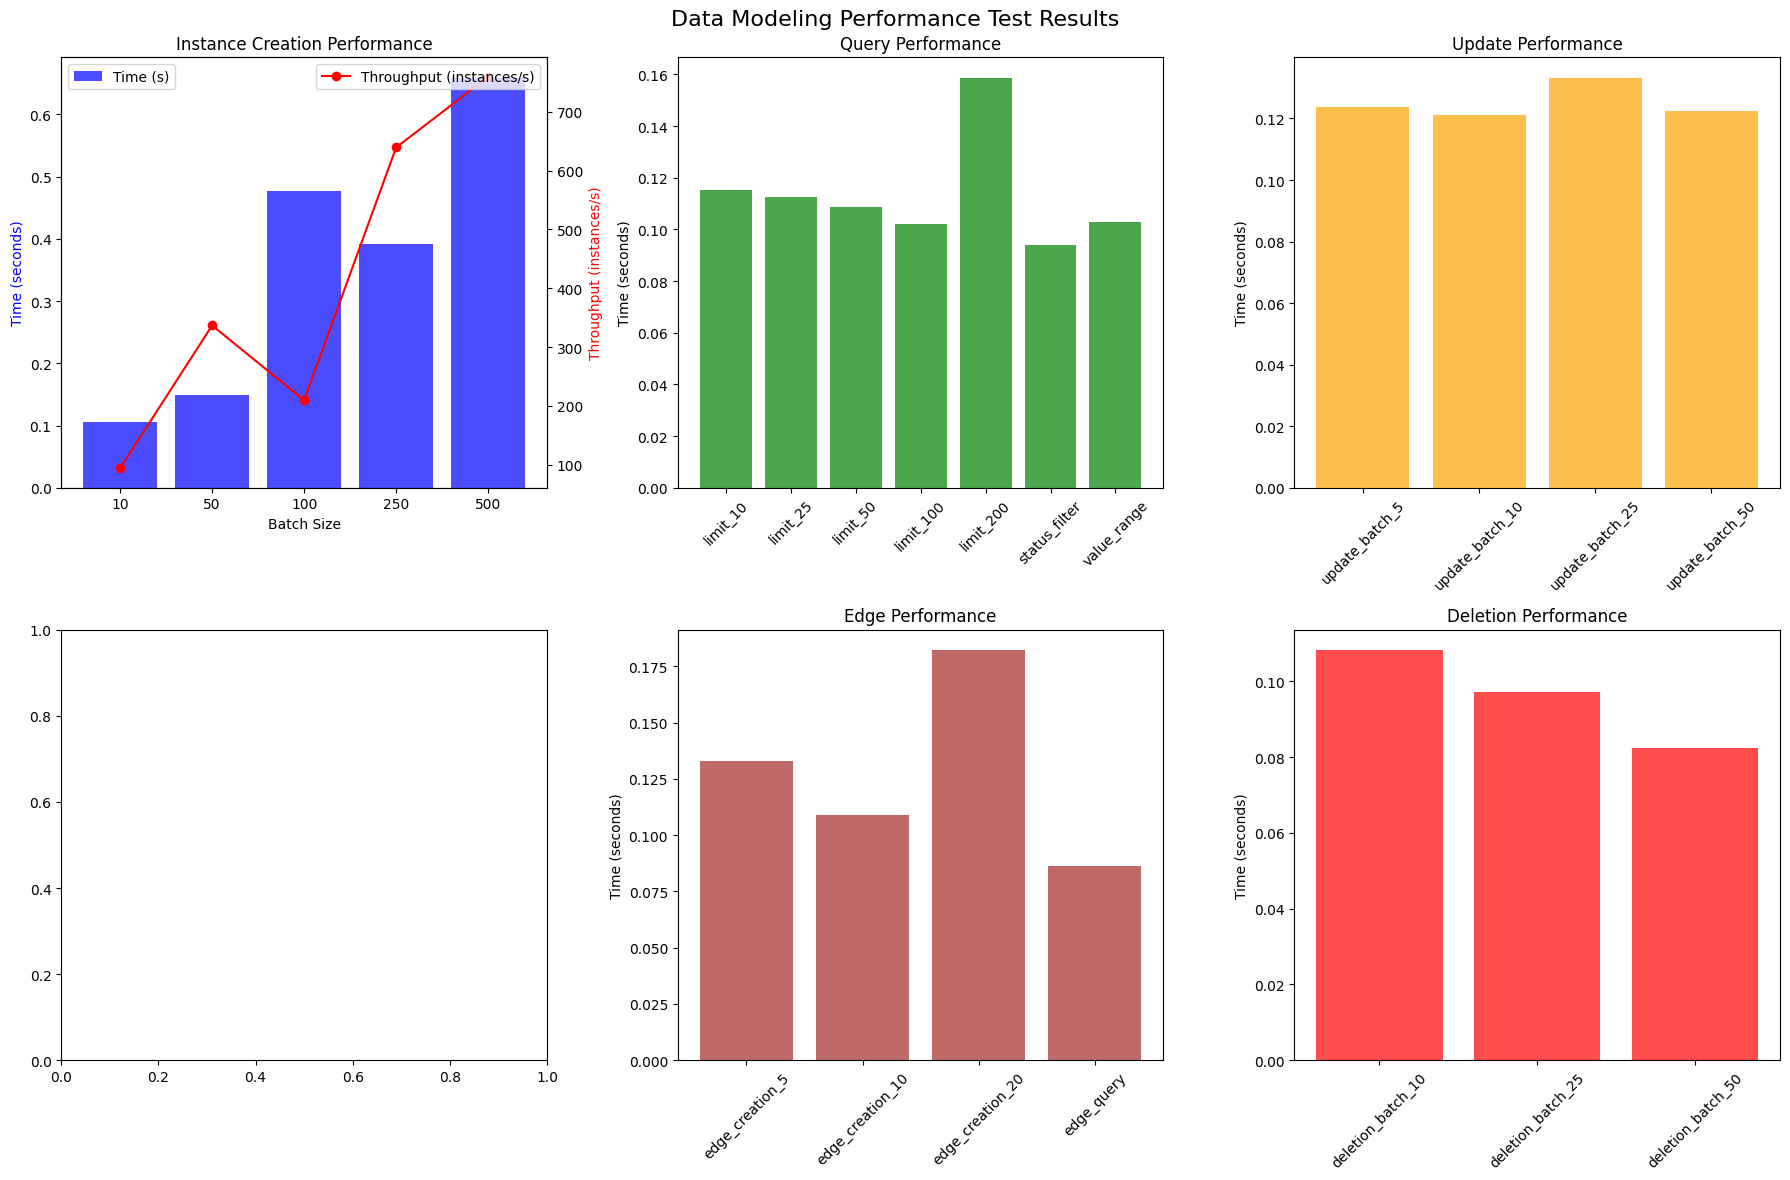

\n✅ Data modeling performance testing complete!
📋 Test space: perf_test_space_1753685995
🏗️ Containers: 2
👁️ Views: 2
📊 Data model: PerfTestDataModel_1753685995
💾 Results can be saved using the PerformanceTracker.save_results() method


In [12]:
# Performance Results Summary and Visualization
def summarize_and_visualize_results():
    """Summarize all data modeling performance test results and create visualizations."""
    
    if not test_space:
        print("❌ No test results to summarize - test space not available.")
        return
    
    print("📈 Data Modeling Performance Test Results Summary")
    print("=" * 60)
    
    # Summarize each test
    if 'creation_results' in globals() and creation_results:
        print("\\n🏭 Instance Creation Performance:")
        for batch_size, results in creation_results.items():
            if results:
                throughput = batch_size / results['mean_time'] if results['mean_time'] > 0 else 0
                print(f"  Batch {batch_size:3d} | {results['mean_time']:.4f}s avg | {throughput:.2f} instances/s")
    
    if 'query_results' in globals() and query_results:
        print("\\n🔍 Instance Query Performance:")
        for test_name, results in query_results.items():
            if results:
                print(f"  {test_name:15} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'update_results' in globals() and update_results:
        print("\\n✏️ Instance Update Performance:")
        for test_name, results in update_results.items():
            if results:
                batch_size = int(test_name.split('_')[-1]) if 'batch' in test_name else 1
                throughput = batch_size / results['mean_time'] if results['mean_time'] > 0 else 0
                print(f"  {test_name:15} | {results['mean_time']:.4f}s avg | {throughput:.2f} updates/s")
    
    if 'edge_results' in globals() and edge_results:
        print("\\n🔗 Edge Performance:")
        for test_name, results in edge_results.items():
            if results:
                print(f"  {test_name:20} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if globals().get('schema_results'):
        print("\\n📋 Schema Operations Performance:")
        for test_name, results in globals().get('schema_results', {}).items():
            if results:
                print(f"  {test_name:20} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'deletion_results' in globals() and deletion_results:
        print("\\n🗑️ Instance Deletion Performance:")
        for test_name, results in deletion_results.items():
            if results:
                batch_size = int(test_name.split('_')[-1]) if 'batch' in test_name else 1
                throughput = batch_size / results['mean_time'] if results['mean_time'] > 0 else 0
                print(f"  {test_name:15} | {results['mean_time']:.4f}s avg | {throughput:.2f} deletions/s")
    
    # Create visualization if matplotlib is available
    try:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Data Modeling Performance Test Results', fontsize=16)
        
        # Plot 1: Instance Creation Performance
        if 'creation_results' in globals() and creation_results:
            ax = axes[0, 0]
            batch_sizes = [size for size, results in creation_results.items() if results]
            times = [creation_results[size]['mean_time'] for size in batch_sizes]
            throughputs = [size / creation_results[size]['mean_time'] for size in batch_sizes]
            
            ax2 = ax.twinx()
            ax.bar([str(size) for size in batch_sizes], times, alpha=0.7, color='blue', label='Time (s)')
            ax2.plot([str(size) for size in batch_sizes], throughputs, 'ro-', label='Throughput (instances/s)')
            
            ax.set_title('Instance Creation Performance')
            ax.set_xlabel('Batch Size')
            ax.set_ylabel('Time (seconds)', color='blue')
            ax2.set_ylabel('Throughput (instances/s)', color='red')
            ax.legend(loc='upper left')
            ax2.legend(loc='upper right')
        
        # Plot 2: Query Performance
        if 'query_results' in globals() and query_results:
            ax = axes[0, 1]
            query_tests = [name for name, results in query_results.items() if results]
            query_times = [query_results[name]['mean_time'] for name in query_tests]
            
            ax.bar(query_tests, query_times, color='green', alpha=0.7)
            ax.set_title('Query Performance')
            ax.set_ylabel('Time (seconds)')
            ax.tick_params(axis='x', rotation=45)
        
        # Plot 3: Update Performance
        if 'update_results' in globals() and update_results:
            ax = axes[0, 2]
            update_tests = [name for name, results in update_results.items() if results]
            update_times = [update_results[name]['mean_time'] for name in update_tests]
            
            ax.bar(update_tests, update_times, color='orange', alpha=0.7)
            ax.set_title('Update Performance')
            ax.set_ylabel('Time (seconds)')
            ax.tick_params(axis='x', rotation=45)
        
        # Plot 4: Schema Operations
        if globals().get('schema_results'):
            ax = axes[1, 0]
            schema_results = globals().get('schema_results', {})
            schema_tests = [name for name, results in schema_results.items() if results]
            schema_times = [schema_results[name]['mean_time'] for name in schema_tests]
            
            ax.bar(schema_tests, schema_times, color='purple', alpha=0.7)
            ax.set_title('Schema Operations Performance')
            ax.set_ylabel('Time (seconds)')
            ax.tick_params(axis='x', rotation=45)
        
        # Plot 5: Edge Performance
        if 'edge_results' in globals() and edge_results:
            ax = axes[1, 1]
            edge_tests = [name for name, results in edge_results.items() if results]
            edge_times = [edge_results[name]['mean_time'] for name in edge_tests]
            
            ax.bar(edge_tests, edge_times, color='brown', alpha=0.7)
            ax.set_title('Edge Performance')
            ax.set_ylabel('Time (seconds)')
            ax.tick_params(axis='x', rotation=45)
        
        # Plot 6: Deletion Performance
        if 'deletion_results' in globals() and deletion_results:
            ax = axes[1, 2]
            deletion_tests = [name for name, results in deletion_results.items() if results]
            deletion_times = [deletion_results[name]['mean_time'] for name in deletion_tests]
            
            ax.bar(deletion_tests, deletion_times, color='red', alpha=0.7)
            ax.set_title('Deletion Performance')
            ax.set_ylabel('Time (seconds)')
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("\\n📊 Install matplotlib for visualizations: pip install matplotlib")
    
    print(f"\\n✅ Data modeling performance testing complete!")
    print(f"📋 Test space: {test_space}")
    print(f"🏗️ Containers: {len(test_containers)}")
    print(f"👁️ Views: {len(test_views)}")
    print(f"📊 Data model: {test_data_model}")
    print(f"💾 Results can be saved using the PerformanceTracker.save_results() method")

# Generate summary
summarize_and_visualize_results()

In [13]:
# Cleanup: Remove test data model, views, containers, and space
def cleanup_test_data_model(space_id, container_ids, view_ids, data_model_id):
    """Clean up all test data modeling objects."""
    
    if not space_id or client is None:
        print("❌ Cannot cleanup: No test space or client not available.")
        return
    
    print(f"🧹 Cleaning up test data modeling objects...")
    
    cleanup_success = {"instances": 0, "edges": 0, "views": 0, "containers": 0, "data_models": 0, "spaces": 0}
    
    try:
        # 1. Delete all instances (nodes and edges) in the space
        print("  Deleting instances...")
        try:
            # List and delete all nodes
            nodes = client.data_modeling.instances.list(instance_type="node", limit=1000)
            if nodes:
                node_ids = [(node.space, node.external_id) for node in nodes if node.space == space_id]
                if node_ids:
                    client.data_modeling.instances.delete(node_ids)
                    cleanup_success["instances"] += len(node_ids)
            
            # List and delete all edges
            edges = client.data_modeling.instances.list(instance_type="edge", limit=1000)
            if edges:
                edge_ids = [(edge.space, edge.external_id) for edge in edges if edge.space == space_id]
                if edge_ids:
                    client.data_modeling.instances.delete(edge_ids)
                    cleanup_success["edges"] += len(edge_ids)
                    
        except Exception as e:
            print(f"    ⚠️ Warning deleting instances: {e}")
        
        # 2. Delete data model
        if data_model_id:
            print("  Deleting data model...")
            try:
                client.data_modeling.data_models.delete([(space_id, data_model_id)])
                cleanup_success["data_models"] += 1
            except Exception as e:
                print(f"    ⚠️ Warning deleting data model: {e}")
        
        # 3. Delete views
        if view_ids:
            print("  Deleting views...")
            try:
                view_references = [(space_id, view_id, "1") for view_id in view_ids]
                client.data_modeling.views.delete(view_references)
                cleanup_success["views"] += len(view_ids)
            except Exception as e:
                print(f"    ⚠️ Warning deleting views: {e}")
        
        # 4. Delete containers
        if container_ids:
            print("  Deleting containers...")
            try:
                container_references = [(space_id, container_id) for container_id in container_ids]
                client.data_modeling.containers.delete(container_references)
                cleanup_success["containers"] += len(container_ids)
            except Exception as e:
                print(f"    ⚠️ Warning deleting containers: {e}")
        
        # 5. Delete additional containers created during testing
        print("  Deleting any additional containers...")
        try:
            all_containers = client.data_modeling.containers.list(space=space_id, limit=100)
            if all_containers:
                additional_containers = [(space_id, container.external_id) for container in all_containers]
                if additional_containers:
                    client.data_modeling.containers.delete(additional_containers)
                    cleanup_success["containers"] += len(additional_containers)
        except Exception as e:
            print(f"    ⚠️ Warning deleting additional containers: {e}")
        
        # 6. Delete space (this should remove anything remaining)
        print("  Deleting space...")
        try:
            client.data_modeling.spaces.delete([space_id])
            cleanup_success["spaces"] += 1
        except Exception as e:
            print(f"    ❌ Error deleting space: {e}")
    
    except Exception as e:
        print(f"❌ Error during cleanup: {e}")
    
    print(f"✅ Cleanup complete!")
    print(f"  Instances deleted: {cleanup_success['instances']}")
    print(f"  Edges deleted: {cleanup_success['edges']}")
    print(f"  Views deleted: {cleanup_success['views']}")
    print(f"  Containers deleted: {cleanup_success['containers']}")
    print(f"  Data models deleted: {cleanup_success['data_models']}")
    print(f"  Spaces deleted: {cleanup_success['spaces']}")

# Uncomment the line below to cleanup test data
# cleanup_test_data_model(test_space, test_containers, test_views, test_data_model)

print("\\n🎯 Data Modeling Performance Testing Tips:")
print("- Data modeling operations are generally slower than time series operations")
print("- Schema operations (containers, views) are heavier than instance operations")
print("- Consider the complexity of your data model when planning performance")
print("- Use appropriate batch sizes for your use case")
print("- Monitor your CDF quota usage during testing")
print("- Test with realistic data volumes and complexity")

print("\\n📝 Next Steps:")
print("- Analyze performance patterns for your specific use case")
print("- Compare different data modeling approaches")
print("- Test with production-like data complexity")
print("- Consider indexing strategies for frequently queried properties")
print("- Plan for data model evolution and migration scenarios")

print("\\n⚠️ Important Notes:")
print("- Always cleanup test data to avoid cluttering your CDF project")
print("- Be aware of CDF limits and quotas when running large-scale tests")
print("- Consider running tests in a dedicated test project")
print("- Data modeling operations can be resource-intensive")

\n🎯 Data Modeling Performance Testing Tips:
- Data modeling operations are generally slower than time series operations
- Schema operations (containers, views) are heavier than instance operations
- Consider the complexity of your data model when planning performance
- Use appropriate batch sizes for your use case
- Monitor your CDF quota usage during testing
- Test with realistic data volumes and complexity
\n📝 Next Steps:
- Analyze performance patterns for your specific use case
- Compare different data modeling approaches
- Test with production-like data complexity
- Consider indexing strategies for frequently queried properties
- Plan for data model evolution and migration scenarios
\n⚠️ Important Notes:
- Always cleanup test data to avoid cluttering your CDF project
- Be aware of CDF limits and quotas when running large-scale tests
- Consider running tests in a dedicated test project
- Data modeling operations can be resource-intensive
